# Battle of Neighborhoods

## Problem description

The business activity within any local market tends to be unevenly distributed, some neighborhoods simply attract more activity than others. Economic development within a neighborhood also tends to have a direct impact on several measures of well-being among its residents.
So, for this reason a fitness expert who is trying to open an own Gym in Toronto, Canada wants to do analysis of the neighborhood in deciding the place to establish the business. 


## Importing libraries

In [35]:
import pandas as pd
import numpy as np
import geocoder
from opencage.geocoder import OpenCageGeocode
import folium
import requests
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

## Data description

The list of neighborhoods in Toronto are fetched from the Wikipedia page. Also, the latitude and longitude of these locations are added by using the geocoder package. By using the foursquare API, we can get a list of various venues that are present in each of the neighborhood. The steps to obtain data are as follows:
- We obtain top 100 venues of each neighborhood in 1000m radius.
    - Using this analyze most common top 10 places of each neighborhood.
    - Then cluster the neighborhoods. 
    -	From this clustering we can decide on a subset of neighborhoods for consideration.
- Once we have the first subset of neighborhoods, then we fetch the details of venues which offer physical fitness such as gyms, yoga studios, spas, pools etc.
    - From this data we can analyze and cluster each neighborhood with what type of venues they have and give out a well data backed judgement of the locality to open a gym. 


### Scraping data from wiki page

Using the pandas library to read the html

In [2]:
wiki_data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
wiki_data.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


#### Cleaning the data

- Removing the not assigned borough
- Replacing the '/' with a ',' where we have multiple entries for Neighborhood
- There are no enteries where we donot have a value for Neighborhood

In [3]:
neighborhood_data = pd.DataFrame(columns = ['Postal code','Borough', 'Neighborhood'], 
                                 data = wiki_data[wiki_data.Borough!='Not assigned'].values)
neighborhood_data.Neighborhood = neighborhood_data.Neighborhood.replace({'/':','},regex=True)
neighborhood_data.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [4]:
print("The size of the data frame read is {}".format(neighborhood_data.shape))

The size of the data frame read is (103, 3)


### Fetching the latitude and longitude

Using geocoder package to get the latitude and longitude
- But this failed so used the csv file provided.

In [5]:
# for i,data in neighborhood_data.iterrows():
#     lat_lng = None
#     while(lat_lng==None):
#         location = geocoder.google('{}, Toronto, Ontario'.format(data['Postal code']))
#         lat_lng = location.latlng
#     neighborhood_data['Latitude'] = lat_lng[0]
#     neighborhood_data['Longitude'] = lat_lng[1]
#     print(i, data['Postal code'])
#     time.sleep(1.0)

#### Reading the coordinates data

The index of the data frame is set to be the Postal code column.

In [6]:
lat_lng = pd.read_csv('./Geospatial_Coordinates.csv')
lat_lng.set_index('Postal Code', inplace=True)
lat_lng.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


#### Merging the latitude and longitude data with neighborhood data

In [7]:
neighborhood_data['Latitude'] = lat_lng.loc[neighborhood_data['Postal code'], 'Latitude'].values
neighborhood_data['Longitude'] = lat_lng.loc[neighborhood_data['Postal code'], 'Longitude'].values
neighborhood_data.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


### Analysing and understanding the data

Let's check how many unique Borough's and Neighborhood's are present. This gives is the idea of number of options available to choose from.

In [8]:
print('The data has {} boroughs and {} neighborhoods.'.format(
        len(neighborhood_data['Borough'].unique()),
        len(neighborhood_data['Neighborhood'].unique())
    )
)

The data has 10 boroughs and 98 neighborhoods.


### Getting the latitude and longitude of the Toronto 

Geocoder package was not working so used open cage geocode

In [9]:
# lat_lng = None
# while(lat_lng==None):
#     location = geocoder.google('Toronto, Ontario')
#     lat_lng = location.latlng
#  = location.latlng[0]
#  = location.latlng[1]
geolocator = OpenCageGeocode("d9151bc21e3c47daa72ac27bf5422c76")
location = geolocator.geocode("Toronto", country="CA")
latitude_TO = location[0]['geometry']['lat']
longitude_TO = location[0]['geometry']['lng']
print("The latitude and longitude of Toronto, CA are {}, {}".format(latitude_TO, longitude_TO))


The latitude and longitude of Toronto, CA are 43.6534817, -79.3839347


### Plotting the neighborhoods on a Map

In [10]:
map_toronto = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhood_data['Latitude'], neighborhood_data['Longitude'], neighborhood_data['Borough'], neighborhood_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Declaring foursquare api 

In [11]:
CLIENT_ID = 'UFX0WT0O50CEQBP4GIIDCPB5FELMNMCMDN50MAJGB0GDZDBV' # your Foursquare ID
CLIENT_SECRET = 'WCNIIINW5HL1SHJBEUSBIRA5FC35GB4BHYAPN2UYCHWYFPRF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UFX0WT0O50CEQBP4GIIDCPB5FELMNMCMDN50MAJGB0GDZDBV
CLIENT_SECRET:WCNIIINW5HL1SHJBEUSBIRA5FC35GB4BHYAPN2UYCHWYFPRF


### Explore the Neighborhoods

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Venues within 1000m radius and top 100

In [13]:
toronto_venues = getNearbyVenues(names=neighborhood_data['Neighborhood'],
                                   latitudes=neighborhood_data['Latitude'],
                                   longitudes=neighborhood_data['Longitude'],
                                   radius=1000, LIMIT=100
                                  )
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store


#### The size of the data frame with venues

In [15]:
print("The size of the venues data frame is {}".format(toronto_venues.shape))

The size of the venues data frame is (4952, 7)


#### The number of unique categories from each venue

In [16]:
print("The number of unique categories are {}".format(len(toronto_venues['Venue Category'].unique())))

The number of unique categories are 327


#### The list of unique categories are as follows

In [17]:
print(toronto_venues['Venue Category'].unique())

['Caribbean Restaurant' 'Park' 'Café' 'Fast Food Restaurant'
 'Grocery Store' 'Fish & Chips Shop' 'Supermarket' 'Pharmacy'
 'Food & Drink Shop' 'Pizza Place' 'Road' 'Bus Stop' 'Train Station'
 'Discount Store' 'Laundry Service' 'Chinese Restaurant' 'Coffee Shop'
 'Convenience Store' 'Shopping Mall' 'Skating Rink' 'Tennis Court'
 'Cosmetics Shop' 'Shop & Service' 'Hockey Arena' 'Portuguese Restaurant'
 'Sporting Goods Shop' "Men's Store" 'Boxing Gym' 'Lounge' 'Golf Course'
 'Gym / Fitness Center' 'Bakery' 'Distribution Center' 'Restaurant'
 'Historic Site' 'Spa' 'Farmers Market' 'Dessert Shop' 'Chocolate Shop'
 'Mediterranean Restaurant' 'Breakfast Spot' 'Performing Arts Venue'
 'Italian Restaurant' 'French Restaurant' 'Theater' 'Pub' 'Tech Startup'
 'Liquor Store' 'Mexican Restaurant' 'Thai Restaurant' 'Event Space'
 'Pool' 'Animal Shelter' 'Shoe Store' 'Asian Restaurant' 'Ice Cream Shop'
 'Sandwich Place' 'Yoga Studio' 'Furniture / Home Store' 'Art Gallery'
 'Diner' 'German Restaurant

#### One hot encoding

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

# # move neighborhood column to the first column
neighborhoodIndex = list(toronto_onehot.columns).index('Neighborhood')
fixed_columns = [toronto_onehot.columns[neighborhoodIndex]] + list(toronto_onehot.columns[:neighborhoodIndex])+list(toronto_onehot.columns[neighborhoodIndex+1:])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
print("The size of the onehot dataframe is {}".format(toronto_onehot.shape))

The size of the onehot dataframe is (4952, 327)


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Agincourt,0.0,0.0,0.0,0.02000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.02,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,"Alderwood , Long Branch",0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,"Bathurst Manor , Wilson Heights , Downsview North",0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.032258,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,"Bedford Park , Lawrence Manor East",0.0,0.0,0.0,0.02439,0.0,0.0,0.0,0.0,0.0,...,0.024390,0.00,0.0,0.0,0.0,0.0,0.02439,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Willowdale , Newtonbrook",0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.032258,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
95,"York Mills , Silver Hills",0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [21]:
print("The new size is {}".format(toronto_grouped.shape))

The new size is (97, 327)


#### Top 10 common venues

In [20]:
# num_top_venues = 10

# for hood in toronto_grouped['Neighborhood']:
#     print("----"+hood+"----")
#     temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
#     temp.columns = ['venue','freq']
#     temp = temp.iloc[1:]
#     temp['freq'] = temp['freq'].astype(float)
#     temp = temp.round({'freq': 2})
#     print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#     print('\n')

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Caribbean Restaurant,Pizza Place,Bakery,Coffee Shop,Sandwich Place,Supermarket,Sri Lankan Restaurant,Latin American Restaurant
1,"Alderwood , Long Branch",Discount Store,Pharmacy,Pizza Place,Convenience Store,Coffee Shop,Sandwich Place,Garden Center,Gas Station,Donut Shop,Liquor Store
2,"Bathurst Manor , Wilson Heights , Downsview North",Convenience Store,Coffee Shop,Bank,Pizza Place,Community Center,Ski Area,Frozen Yogurt Shop,Fried Chicken Joint,Sushi Restaurant,Supermarket
3,Bayview Village,Grocery Store,Bank,Gas Station,Japanese Restaurant,Chinese Restaurant,Park,Shopping Mall,Restaurant,Café,Trail
4,"Bedford Park , Lawrence Manor East",Italian Restaurant,Coffee Shop,Bank,Restaurant,Sandwich Place,Fast Food Restaurant,Bridal Shop,Skating Rink,Intersection,Juice Bar


## Clustering the Neighborhoods

Using k-means clustering

In [24]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 0, 0, 0, 0, 0, 0])

### Including cluster and the most common venues in data frame

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhood_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Park,Convenience Store,Shopping Mall,Pharmacy,Bus Stop,Cosmetics Shop,Train Station,Tennis Court,Shop & Service,Chinese Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,4.0,Coffee Shop,Hockey Arena,Gym / Fitness Center,Pizza Place,Park,Sporting Goods Shop,Boxing Gym,Men's Store,Lounge,Golf Course
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Café,Theater,Park,Pub,Diner,Breakfast Spot,Bakery,Restaurant,Italian Restaurant
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,0.0,Fast Food Restaurant,Coffee Shop,Restaurant,Accessories Store,Fried Chicken Joint,Clothing Store,Vietnamese Restaurant,Furniture / Home Store,Dessert Shop,Sushi Restaurant
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Park,Sushi Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Ramen Restaurant,Gastropub,Burger Joint,Bubble Tea Shop


In [26]:
toronto_merged['Cluster Labels'].dropna(inplace=True)

### Visualizing the clusters

In [27]:
map_clusters = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## Analysing the Clusters

In [28]:
toronto_merged.reset_index(inplace=True)

### Cluster 1

This cluster has the potential neighborhood for establishing a Yoga studio, as it has most occurances of Fitness centers and Gyms then any other cluster in top 3 common venues

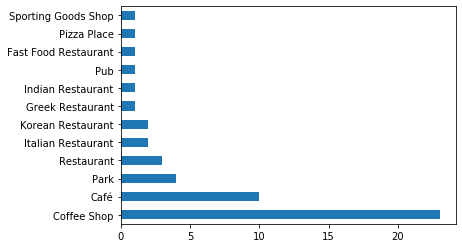

In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels']==0]['1st Most Common Venue'].value_counts().plot(kind='barh')

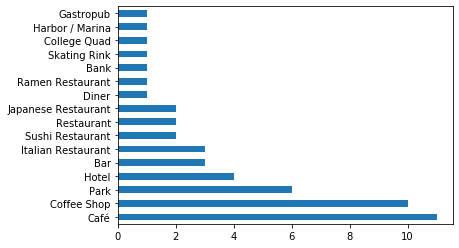

In [61]:
toronto_merged.loc[toronto_merged['Cluster Labels']==0]['2nd Most Common Venue'].value_counts().plot(kind='barh')

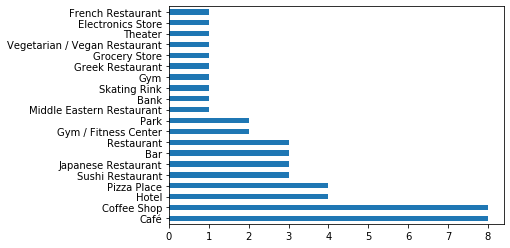

In [62]:
toronto_merged.loc[toronto_merged['Cluster Labels']==0]['3rd Most Common Venue'].value_counts().plot(kind='barh')

### Cluster 2

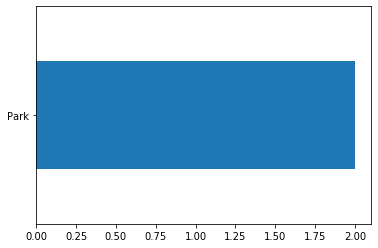

In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels']==1]['1st Most Common Venue'].value_counts().plot(kind='barh')

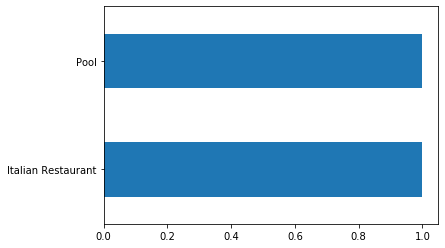

In [64]:
toronto_merged.loc[toronto_merged['Cluster Labels']==1]['2nd Most Common Venue'].value_counts().plot(kind='barh')

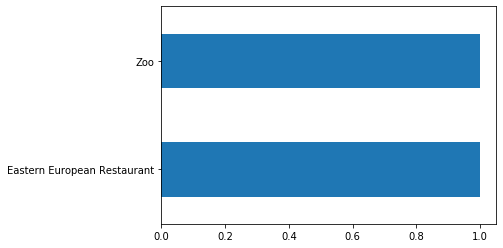

In [65]:
toronto_merged.loc[toronto_merged['Cluster Labels']==1]['3rd Most Common Venue'].value_counts().plot(kind='barh')

### Cluster 3

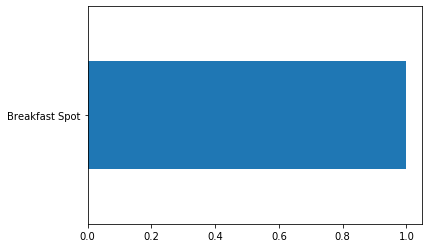

In [66]:
toronto_merged.loc[toronto_merged['Cluster Labels']==2]['1st Most Common Venue'].value_counts().plot(kind='barh')

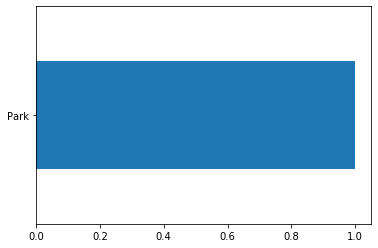

In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels']==2]['2nd Most Common Venue'].value_counts().plot(kind='barh')

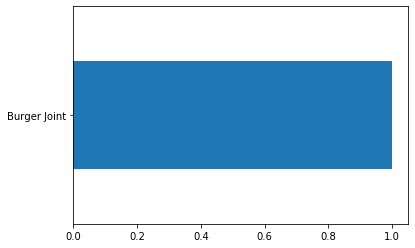

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels']==2]['3rd Most Common Venue'].value_counts().plot(kind='barh')

### Cluster 4

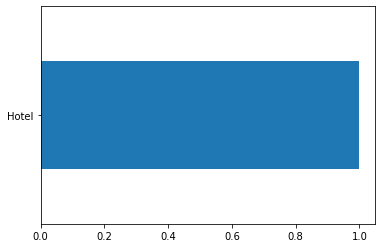

In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels']==3]['1st Most Common Venue'].value_counts().plot(kind='barh')

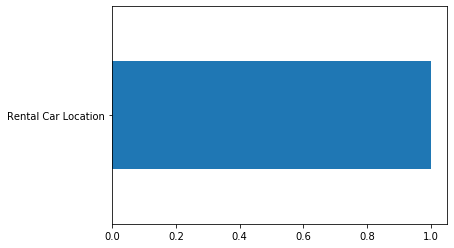

In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels']==3]['2nd Most Common Venue'].value_counts().plot(kind='barh')

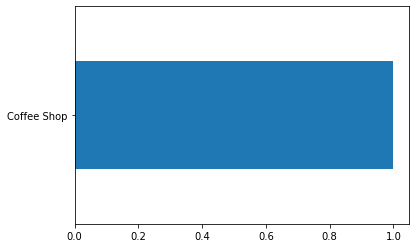

In [71]:
toronto_merged.loc[toronto_merged['Cluster Labels']==3]['3rd Most Common Venue'].value_counts().plot(kind='barh')

### Cluster 5

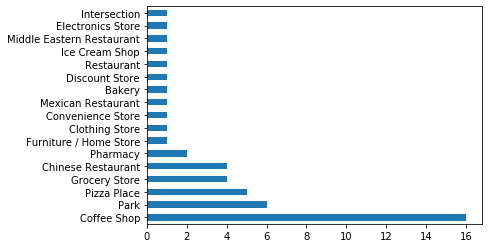

In [72]:
toronto_merged.loc[toronto_merged['Cluster Labels']==4]['1st Most Common Venue'].value_counts().plot(kind='barh')

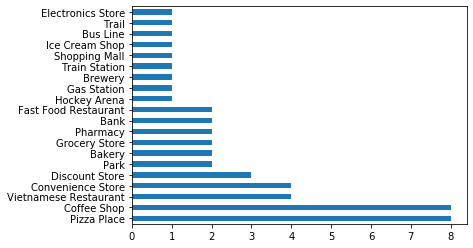

In [73]:
toronto_merged.loc[toronto_merged['Cluster Labels']==4]['2nd Most Common Venue'].value_counts().plot(kind='barh')

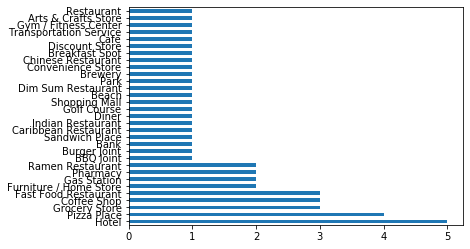

In [74]:
toronto_merged.loc[toronto_merged['Cluster Labels']==4]['3rd Most Common Venue'].value_counts().plot(kind='barh')

## 1st Cluster selected for further analysis

As this has most occurances of Gyms and fitness centers. 

In [81]:
Cluster1_data = toronto_merged.loc[toronto_merged['Cluster Labels']==0,toronto_merged.columns[1:6]]
Cluster1_data.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
7,M3B,North York,Don Mills,43.745906,-79.352188
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


### Checking the size of the data

In [83]:
print("The number of entries we have are {}".format(Cluster1_data.shape[0]))

The number of entries we have are 50


#### We are down to 50 from 98 neighborhoods

### Fetching fitness centers in these cluster 1 neighborhoods

In [128]:
def getNearbyVenuesByCategory(names, latitudes, longitudes, categoryId, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [130]:
# This is the category ID for Outdoors & Recreation
categoryID = "4d4b7105d754a06377d81259"

Cluster1_venues = getNearbyVenuesByCategory(Cluster1_data['Neighborhood'], 
                                            Cluster1_data['Latitude'], 
                                            Cluster1_data['Longitude'],
                                            categoryID
                                           )
Cluster1_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Sackville Playground,43.654656,-79.359871,Park
1,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
2,"Regent Park , Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
3,"Regent Park , Harbourfront",43.65426,-79.360636,Lift Corktown,43.656475,-79.357258,Gym
4,"Regent Park , Harbourfront",43.65426,-79.360636,Gym @ The George,43.653410,-79.357630,Gym


In [131]:
print("The size of the venues data is {}".format(Cluster1_venues.shape[0]))

The size of the venues data is 1224


In [137]:
print(Cluster1_venues['Venue Category'].unique())

['Park' 'Distribution Center' 'Historic Site' 'Gym' 'Gym / Fitness Center'
 'Sculpture Garden' 'Dog Run' 'Yoga Studio' 'Other Great Outdoors'
 'Playground' 'Pool' 'Track' 'Soccer Field' 'Surf Spot' 'Forest'
 'Botanical Garden' 'Dive Spot' 'Beach' 'Skating Rink' 'Harbor / Marina'
 'Farm' 'Boxing Gym' 'Athletics & Sports' 'Garden' 'Lake' 'Field' 'Bridge'
 'Gym Pool' 'Trail' 'Baseball Field' 'Golf Driving Range' 'Tennis Court'
 'Plaza' 'College Rec Center' 'Skate Park' 'Scenic Lookout' 'Hotel Pool'
 'Office' 'Martial Arts Dojo' 'Basketball Court' 'Gymnastics Gym'
 'Cemetery' 'Fountain' 'Pilates Studio' 'College Gym' 'Recreation Center'
 'Summer Camp' 'Campground' 'Arcade' 'Non-Profit' 'Flower Shop' 'Stables'
 'Residential Building (Apartment / Condo)' 'Well' 'Lighthouse'
 'Monument / Landmark' 'Apres Ski Bar' 'History Museum' 'Boat or Ferry'
 'Roof Deck' 'Pet Service' 'Outdoors & Recreation' 'Climbing Gym'
 'Stadium' 'Cycle Studio' 'General Entertainment' 'College Stadium'
 'Swim School' 

In [138]:
print("The number of Yoga studios are {}".format(len(Cluster1_venues.loc[Cluster1_venues['Venue Category']=='Yoga Studio'])))

The number of Yoga studios are 75


#### One hot encoding

In [139]:
# one hot encoding
Cluster1_onehot = pd.get_dummies(Cluster1_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Cluster1_onehot['Neighborhood'] = Cluster1_venues['Neighborhood']

# # move neighborhood column to the first column
neighborhoodIndex = list(Cluster1_onehot.columns).index('Neighborhood')
fixed_columns = [Cluster1_onehot.columns[neighborhoodIndex]] + list(Cluster1_onehot.columns[:neighborhoodIndex])+list(Cluster1_onehot.columns[neighborhoodIndex+1:])
Cluster1_onehot = Cluster1_onehot[fixed_columns]

Cluster1_onehot.head()

,Neighborhood,Apres Ski Bar,Arcade,Athletics & Sports,Baseball Field,Basketball Court,Bath House,Beach,Beer Garden,Bike Trail,...,Stadium,Summer Camp,Surf Spot,Swim School,Tennis Court,Track,Trail,Tree,Well,Yoga Studio
0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
print("The size of the onehot dataframe is {}".format(Cluster1_onehot.shape))

The size of the onehot dataframe is (1224, 81)


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [147]:
Cluster1_grouped = Cluster1_onehot.groupby('Neighborhood').mean().reset_index()
Cluster1_grouped

,Neighborhood,Apres Ski Bar,Arcade,Athletics & Sports,Baseball Field,Basketball Court,Bath House,Beach,Beer Garden,Bike Trail,...,Stadium,Summer Camp,Surf Spot,Swim School,Tennis Court,Track,Trail,Tree,Well,Yoga Studio
0,"Bedford Park , Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.250000
1,Berczy Park,0.000000,0.000000,0.073171,0.000000,0.024390,0.000000,0.024390,0.000000,0.000000,...,0.000000,0.024390,0.000000,0.00,0.024390,0.000000,0.024390,0.0,0.000000,0.048780
2,"Birch Cliff , Cliffside West",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.000000,0.083333,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027778,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.111111
4,Business reply mail Processing CentrE,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.062500,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.062500
5,"CN Tower , King and Spadina , Railway Lands , ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.2,0.000000,0.000000
6,Canada Post Gateway Processing Centre,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,Central Bay Street,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.068182
8,Christie,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.133333
9,Church and Wellesley,0.000000,0.000000,0.022727,0.000000,0.000000,0.022727,0.000000,0.022727,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.045455


In [149]:
print("The new size is {}".format(Cluster1_grouped.shape))

The new size is (49, 81)


#### Top 10 common venues

In [150]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [170]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Cluster1_venues_sorted = pd.DataFrame(columns=columns)
Cluster1_venues_sorted['Neighborhood'] = Cluster1_grouped['Neighborhood']

for ind in np.arange(Cluster1_grouped.shape[0]):
    Cluster1_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Cluster1_grouped.iloc[ind, :], num_top_venues)

Cluster1_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bedford Park , Lawrence Manor East",Yoga Studio,Gym / Fitness Center,Gym,Playground,Forest,Distribution Center,Dive Spot,Dog Run,Farm,Field
1,Berczy Park,Gym,Other Great Outdoors,Gym / Fitness Center,Athletics & Sports,Pool,Dog Run,Park,Yoga Studio,Summer Camp,Sculpture Garden
2,"Birch Cliff , Cliffside West",Park,General Entertainment,Skating Rink,College Stadium,Yoga Studio,Flower Shop,Distribution Center,Dive Spot,Dog Run,Farm
3,"Brockton , Parkdale Village , Exhibition Place",Park,Yoga Studio,Gym,Athletics & Sports,Gym / Fitness Center,Garden,Field,Dog Run,Playground,Scenic Lookout
4,Business reply mail Processing CentrE,Gym / Fitness Center,Skate Park,Athletics & Sports,Park,Garden,Field,Other Great Outdoors,Playground,Scenic Lookout,Yoga Studio


## Clustering the Neighborhoods

Using k-means clustering

In [168]:
# set number of clusters
kclusters = 3

Cluster1_grouped_clustering = Cluster1_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Cluster1_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 2, 2, 1, 0, 2, 2, 2])

### Including cluster and the most common venues in data frame

In [171]:
# add clustering labels
Cluster1_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Cluster1_merged = neighborhood_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Cluster1_merged = Cluster1_merged.join(Cluster1_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Cluster1_merged.head() # check the last columns!

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M4A,North York,Victoria Village,43.725882,-79.315572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,2.0,Gym,Park,Yoga Studio,Gym / Fitness Center,Other Great Outdoors,Sculpture Garden,Beach,Pool,Botanical Garden,Distribution Center
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,2.0,Athletics & Sports,Gym / Fitness Center,Other Great Outdoors,Skating Rink,Boxing Gym,Yoga Studio,Forest,Dive Spot,Dog Run,Farm
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,2.0,Gym / Fitness Center,Gym,Park,Sculpture Garden,Athletics & Sports,Field,Gym Pool,Bridge,Garden,Lake


In [172]:
Cluster1_merged['Cluster Labels'].dropna(inplace=True)

### Visualizing the clusters

In [173]:
map_clusters = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Cluster1_merged['Latitude'], Cluster1_merged['Longitude'], Cluster1_merged['Neighborhood'], Cluster1_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## Analysing the Clusters

From analysis, cluster 2 has the potential neighborhood for establishing a Yoga studio, as it has less occurances of Yoga studios among the other two clusters.

In [174]:
Cluster1_merged.reset_index(inplace=True)

### Cluster 1

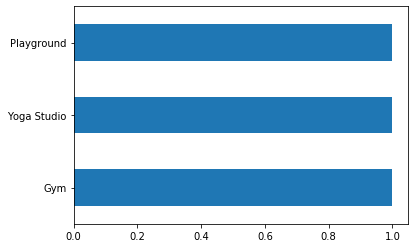

In [175]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==0]['1st Most Common Venue'].value_counts().plot(kind='barh')

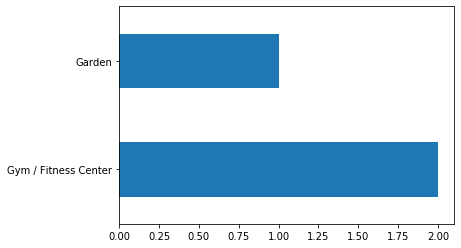

In [176]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==0]['2nd Most Common Venue'].value_counts().plot(kind='barh')

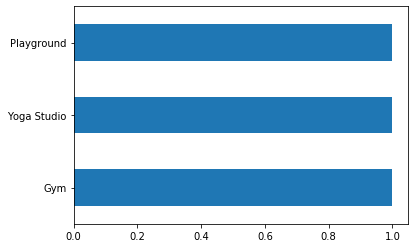

In [177]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==0]['3rd Most Common Venue'].value_counts().plot(kind='barh')

### Cluster 2

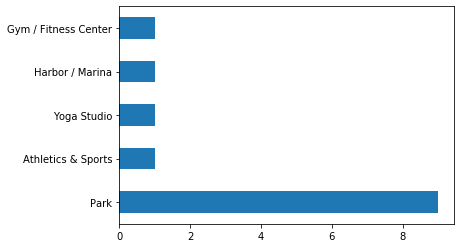

In [178]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==1]['1st Most Common Venue'].value_counts().plot(kind='barh')

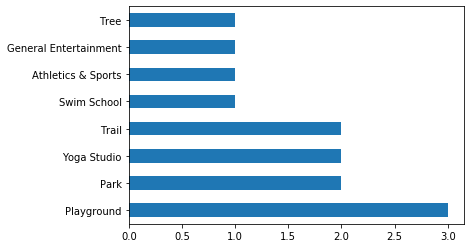

In [179]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==1]['2nd Most Common Venue'].value_counts().plot(kind='barh')

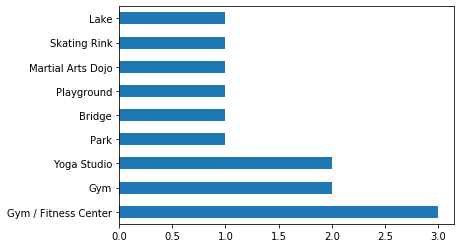

In [180]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==1]['3rd Most Common Venue'].value_counts().plot(kind='barh')

### Cluster 3

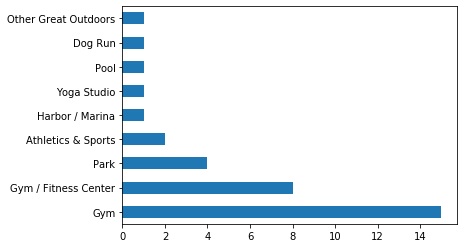

In [181]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==2]['1st Most Common Venue'].value_counts().plot(kind='barh')

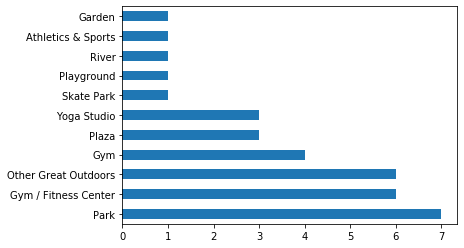

In [182]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==2]['2nd Most Common Venue'].value_counts().plot(kind='barh')

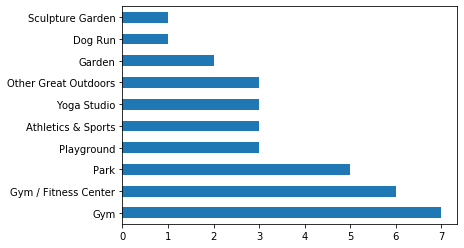

In [183]:
Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==2]['3rd Most Common Venue'].value_counts().plot(kind='barh')

## Analyzing cluster 2

In [184]:
FitnessCluster2_data = Cluster1_merged.loc[Cluster1_merged['Cluster Labels']==1]
FitnessCluster2_data.head()

,index,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,19,M4E,East Toronto,The Beaches,43.676357,-79.293031,1.0,Park,Playground,Martial Arts Dojo,Other Great Outdoors,Yoga Studio,Bridge,Dog Run,Pilates Studio,College Gym,Recreation Center
35,35,M4J,East York,East Toronto,43.685347,-79.338106,1.0,Park,Athletics & Sports,Playground,Yoga Studio,Fountain,Dive Spot,Dog Run,Farm,Field,Flower Shop
47,47,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572,1.0,Park,Playground,Gym,Athletics & Sports,Yoga Studio,Soccer Field,Field,Other Great Outdoors,Gym / Fitness Center,Surf Spot
52,52,M2M,North York,"Willowdale , Newtonbrook",43.789053,-79.408493,1.0,Park,Trail,Yoga Studio,Fountain,Distribution Center,Dive Spot,Dog Run,Farm,Field,Flower Shop
58,58,M1N,Scarborough,"Birch Cliff , Cliffside West",43.692657,-79.264848,1.0,Park,General Entertainment,Skating Rink,College Stadium,Yoga Studio,Flower Shop,Distribution Center,Dive Spot,Dog Run,Farm


#### Checking the size of the data

In [188]:
print("The number of neighborhood options are {}".format(FitnessCluster2_data.shape[0]))

The number of neighborhood options are: 13


### Removing neighborhoods where Yoga studios is among top 3 most common venues

In [191]:
FitnessCluster2_without_Yoga_data = FitnessCluster2_data.loc[(Cluster1_merged['1st Most Common Venue']!='Yoga Studio')&
                                                            (Cluster1_merged['2nd Most Common Venue']!='Yoga Studio')&
                                                            (Cluster1_merged['3rd Most Common Venue']!='Yoga Studio')]
FitnessCluster2_without_Yoga_data.head()

,index,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,19,M4E,East Toronto,The Beaches,43.676357,-79.293031,1.0,Park,Playground,Martial Arts Dojo,Other Great Outdoors,Yoga Studio,Bridge,Dog Run,Pilates Studio,College Gym,Recreation Center
35,35,M4J,East York,East Toronto,43.685347,-79.338106,1.0,Park,Athletics & Sports,Playground,Yoga Studio,Fountain,Dive Spot,Dog Run,Farm,Field,Flower Shop
47,47,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572,1.0,Park,Playground,Gym,Athletics & Sports,Yoga Studio,Soccer Field,Field,Other Great Outdoors,Gym / Fitness Center,Surf Spot
58,58,M1N,Scarborough,"Birch Cliff , Cliffside West",43.692657,-79.264848,1.0,Park,General Entertainment,Skating Rink,College Stadium,Yoga Studio,Flower Shop,Distribution Center,Dive Spot,Dog Run,Farm
61,61,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1.0,Gym / Fitness Center,Swim School,Lake,Park,Yoga Studio,Forest,Distribution Center,Dive Spot,Dog Run,Farm


#### Checking the size of the data

In [192]:
print("The number of neighborhood options are {}".format(FitnessCluster2_without_Yoga_data.shape[0]))

The number of neighborhood options are 8


## Finally we have 8 potential neighborhoods to establish a Yoga studio

In [193]:
FitnessCluster2_without_Yoga_data

,index,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,19,M4E,East Toronto,The Beaches,43.676357,-79.293031,1.0,Park,Playground,Martial Arts Dojo,Other Great Outdoors,Yoga Studio,Bridge,Dog Run,Pilates Studio,College Gym,Recreation Center
35,35,M4J,East York,East Toronto,43.685347,-79.338106,1.0,Park,Athletics & Sports,Playground,Yoga Studio,Fountain,Dive Spot,Dog Run,Farm,Field,Flower Shop
47,47,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572,1.0,Park,Playground,Gym,Athletics & Sports,Yoga Studio,Soccer Field,Field,Other Great Outdoors,Gym / Fitness Center,Surf Spot
58,58,M1N,Scarborough,"Birch Cliff , Cliffside West",43.692657,-79.264848,1.0,Park,General Entertainment,Skating Rink,College Stadium,Yoga Studio,Flower Shop,Distribution Center,Dive Spot,Dog Run,Farm
61,61,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1.0,Gym / Fitness Center,Swim School,Lake,Park,Yoga Studio,Forest,Distribution Center,Dive Spot,Dog Run,Farm
68,68,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,1.0,Park,Trail,Gym / Fitness Center,Basketball Court,Bike Trail,Yoga Studio,Fountain,Dive Spot,Dog Run,Farm
83,83,M4T,Central Toronto,"Moore Park , Summerhill East",43.689574,-79.383160,1.0,Park,Playground,Bridge,Gym,Trail,Tennis Court,Dog Run,Other Great Outdoors,Field,Distribution Center
87,87,M5V,Downtown Toronto,"CN Tower , King and Spadina , Railway Lands , ...",43.628947,-79.394420,1.0,Harbor / Marina,Tree,Park,Island,Sculpture Garden,Forest,Distribution Center,Dive Spot,Dog Run,Farm


### Plotting the neighborhoods on a Map also answer in red marker

In [195]:
map_toronto = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(FitnessCluster2_without_Yoga_data['Latitude'], FitnessCluster2_without_Yoga_data['Longitude'], FitnessCluster2_without_Yoga_data['Borough'], FitnessCluster2_without_Yoga_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    if neighborhood == "Moore Park , Summerhill East":
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)
    else:
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)  
    
map_toronto

# Final result

By looking among the data, the best place to establish a Yoga studio is Moore Park , Summerhill East in Central Toronto. As from the most common top 10 venues among fitness centers it is lacking a Yoga studio in the combination, where as all the other neighborhoods have it.